# Лабораторная работа 8: Текстовые эмбендинги

Тема: Текстовые эмбендинги. Работа с предобученными моделями эмбендингов.

В этом ноутбуке:
- Загружаются две предобученные модели: GloVe (glove-wiki-gigaword-100) и FastText (fasttext-wiki-news-subwords-300) через gensim.downloader.
- Реализованы: поиск семантически схожих слов, решение аналогий (word_a : word_b :: word_c : ?), визуализация 20–30 слов с помощью PCA.
- Даны выводы и ответы на вопросы лабораторной работы.

Примечание: модели загружаются из gensim-data и могут быть большими — загрузка потребует времени и сети.

In [2]:
# Установите зависимости (выполните один раз при необходимости)
%pip install -q gensim matplotlib scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vladk\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# Импорты и загрузка моделей через gensim.downloader
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sns.set(style='whitegrid', rc={'figure.figsize':(10,6)})

model_keys = {
    'GloVe (100d)': 'glove-wiki-gigaword-100',
    'FastText (300d)': 'fasttext-wiki-news-subwords-300'
}
models = {}
for display_name, key in model_keys.items():
    print(f"Загружаю {display_name} ({key}). Это может занять время...")
    models[display_name] = api.load(key)
    print(f"Модель {display_name} загружена. Размер словаря: {len(models[display_name].key_to_index)}")


Загружаю GloVe (100d) (glove-wiki-gigaword-100). Это может занять время...
Модель GloVe (100d) загружена. Размер словаря: 400000
Загружаю FastText (300d) (fasttext-wiki-news-subwords-300). Это может занять время...
Модель FastText (300d) загружена. Размер словаря: 999999


In [18]:
# Вспомогательные функции: похожие слова и аналогии
def most_similar_safe(model, word, topn=10):
    try:
        return model.most_similar(positive=[word], topn=topn)
    except KeyError:
        return f"Слова '{word}' нет в словаре модели."

def analogy_safe(model, a, b, c, topn=5):
    """Решает аналогию: a -> b, c -> ? (возвращает topn кандидатов)
    Использует most_similar(positive=[b, c], negative=[a])."""
    try:
        return model.most_similar(positive=[a, c], negative=[b], topn=topn)
    except KeyError as e:
        return f"Ошибка: {e}"


In [19]:
# Демонстрация похожих слов по списку слов
query_words = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'belarus', 'minsk',
               'eiffel', 'tower', 'pizza', 'italy', 'rome', 'computer', 'python']

for name, model in models.items():
    print('\n--- Результаты для модели:', name, '---')
    for w in query_words:
        res = most_similar_safe(model, w, topn=5)
        print(f"{w}: {res}")



--- Результаты для модели: GloVe (100d) ---
king: [('prince', 0.7682328820228577), ('queen', 0.7507690787315369), ('son', 0.7020888328552246), ('brother', 0.6985775232315063), ('monarch', 0.6977890729904175)]
queen: [('princess', 0.7947245240211487), ('king', 0.7507690191268921), ('elizabeth', 0.7355712056159973), ('royal', 0.7065026164054871), ('lady', 0.7044796943664551)]
man: [('woman', 0.8323495388031006), ('boy', 0.7914870977401733), ('one', 0.7788748741149902), ('person', 0.7526816725730896), ('another', 0.7522234916687012)]
woman: [('girl', 0.8472671508789062), ('man', 0.832349419593811), ('mother', 0.827568769454956), ('boy', 0.7720510363578796), ('she', 0.7632068395614624)]
paris: [('prohertrib', 0.7994136214256287), ('france', 0.7481585741043091), ('london', 0.7337676882743835), ('brussels', 0.7037922143936157), ('french', 0.6930580735206604)]
france: [('belgium', 0.8076421618461609), ('french', 0.8004378080368042), ('britain', 0.7950528264045715), ('spain', 0.75574636459350

In [26]:
# Примеры аналогий
analogies = [
    ('king', 'man', 'woman'),  
    ('paris', 'france', 'belarus'),  
    ('italy', 'pizza', 'potato')
]
for name, model in models.items():
    print(f"\n=== Аналогии для модели: {name} ===")
    for a, b, c in analogies:
        print(f"Аналогия: {a} -> {b}, {c} -> ?")
        print(analogy_safe(model, a, b, c, topn=5))



=== Аналогии для модели: GloVe (100d) ===
Аналогия: king -> man, woman -> ?
[('queen', 0.7698540687561035), ('monarch', 0.6843381524085999), ('throne', 0.6755736470222473), ('daughter', 0.6594556570053101), ('princess', 0.6520534157752991)]
Аналогия: paris -> france, belarus -> ?
[('minsk', 0.8076947331428528), ('moscow', 0.7415991425514221), ('kiev', 0.7119989395141602), ('ukraine', 0.6318672895431519), ('belarusian', 0.6208816766738892)]
Аналогия: italy -> pizza, potato -> ?
[('hungary', 0.6157017946243286), ('spain', 0.5972033739089966), ('portugal', 0.5969147682189941), ('brazil', 0.5964059829711914), ('germany', 0.5851757526397705)]

=== Аналогии для модели: FastText (300d) ===
Аналогия: king -> man, woman -> ?
[('queen', 0.7786749005317688), ('queen-mother', 0.7143871784210205), ('king-', 0.6981282234191895), ('queen-consort', 0.6724597811698914), ('monarch', 0.6666999459266663)]
Аналогия: paris -> france, belarus -> ?
[('vulytsia', 0.5980396866798401), ('belarussian', 0.5892407

Для модели 'GloVe (100d)' найдено 24/24 слов. Отсутствуют: []


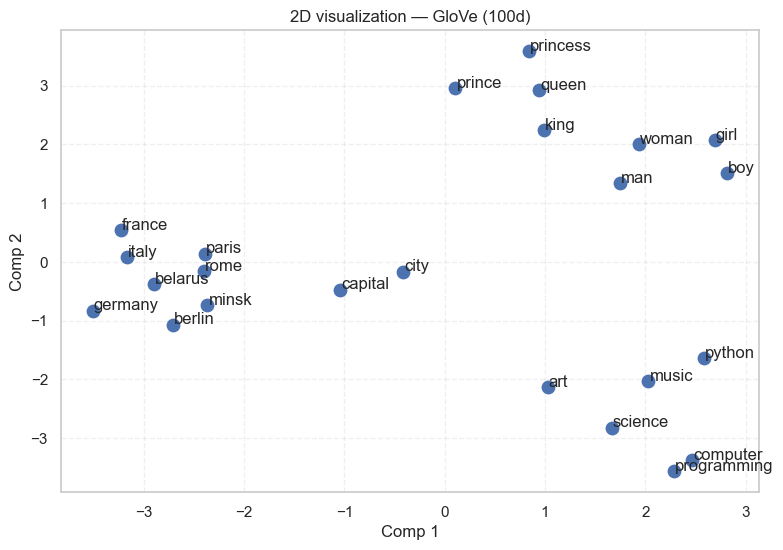

Для модели 'FastText (300d)' найдено 24/24 слов. Отсутствуют: []


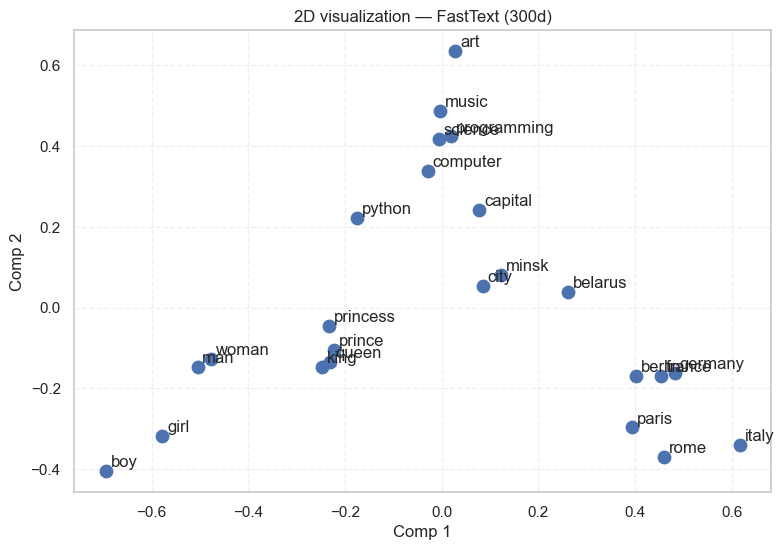

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

vis_words = ['king','queen','man','woman','prince','princess','boy','girl',
             'paris','france','berlin','germany','minsk','belarus','rome','italy',
             'computer','python','programming','music','art','science','city','capital']

def visualize_model_words(model, words, title='', use_tsne=False, random_state=42):
    """
    Визуализирует векторы слов из модели.
    - model: объект gensim модели (word vectors) с attribute key_to_index и поддержкой model[w]
    - words: список слов для визуализации
    - title: заголовок графика
    - use_tsne: если True, использует t-SNE поверх PCA (рекомендуется для больших размерностей)
    - random_state: для воспроизводимости
    """
    present = [w for w in words if w in model.key_to_index]
    missing = [w for w in words if w not in model.key_to_index]
    print(f"Для модели '{title}' найдено {len(present)}/{len(words)} слов. Отсутствуют: {missing}")
    if not present:
        print('Нет слов для визуализации.')
        return

    X = np.array([model[w] for w in present])
    n_samples, n_features = X.shape

    # Если размерность признаков мала (<=50) — делаем прямой PCA->2
    # Если большая, сначала уменьшаем до min(50, n_samples, n_features), затем до 2.
    # Всегда гарантируем, что n_components <= min(n_samples, n_features)
    if n_features > 50 and n_samples > 2:
        n_pca_first = min(50, n_samples, n_features)
        pca_first = PCA(n_components=n_pca_first, random_state=random_state)
        X_reduced = pca_first.fit_transform(X)
    else:
        X_reduced = X

    # Дальше делаем финальную проекцию в 2D.
    if use_tsne and X_reduced.shape[0] >= 2:
        # t-SNE часто даёт лучшее распределение для визуализации семантических кластеров,
        # но медленнее и не детерминирован без random_state.
        tsne = TSNE(n_components=2, init='pca', random_state=random_state, learning_rate='auto')
        X2 = tsne.fit_transform(X_reduced)
    else:
        # Снова PCA, но с числом компонент = 2 (гарантировано допустимо)
        n_final = min(2, X_reduced.shape[0], X_reduced.shape[1])
        if n_final < 2:
            # Если осталось меньше 2 компонентов (например, 1 слово или 1-d векторы),
            # расширяем координаты, чтобы можно было корректно отобразить.
            X2 = np.zeros((X_reduced.shape[0], 2))
            X2[:,0] = X_reduced[:,0] if X_reduced.shape[1] >= 1 else 0
        else:
            pca2 = PCA(n_components=2, random_state=random_state)
            X2 = pca2.fit_transform(X_reduced)

    plt.figure(figsize=(9,6))
    plt.scatter(X2[:,0], X2[:,1], s=80, color='C0')
    for i, w in enumerate(present):
        plt.annotate(w, (X2[i,0]+0.01, X2[i,1]+0.01))
    plt.title(f'2D visualization — {title}')
    plt.xlabel('Comp 1')
    plt.ylabel('Comp 2')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()


# Пример использования в ноутбуке:
for name, model in models.items():
    visualize_model_words(model, vis_words, title=name, use_tsne=False)

## Выводы и ответы на вопросы

1) Принцип выделения эмбендингов выбранных моделей:
- GloVe (Global Vectors) — матричный метод, который обучается на глобальной статистике со-употреблений слов из корпуса. GloVe сводит задачу к факторизации матрицы логарифмов совместных встречаемостей и обучает векторные представления таким образом, чтобы скалярные произведения векторов соответствовали лог-частотам со-употреблений.
- FastText — расширение модели word2vec, где слово представляется как сумма векторов его n-грамм (подслов). Это позволяет моделировать морфологию и корректно работать с редкими словами и формами слова.

2) Какой параметр характеризует семантическую близость слов?
- Обычно для измерения семантической близости используется косинусная близость (cosine similarity) между векторами слов. Чем ближе косинус к 1, тем более семантически схожи слова.

3) Как можно обучить свои текстовые эмбендинги и какие библиотеки предоставляют модели для обучения?
- Обучить можно с помощью методов Word2Vec (skip-gram, CBOW), GloVe (факторизация матрицы со-употреблений) или FastText (учет n-грамм). Библиотеки и инструменты: gensim (Word2Vec, FastText), Facebook fastText (официальная реализация), GloVe (официальный код от Stanford), а также современные фреймворки PyTorch и TensorFlow для кастомных реализаций и обучения на больших корпусах.

4) Какая модель лучше справляется с семантическими аналогиями?
- В целом, FastText часто лучше работает с редкими словами и морфологией, а GloVe даёт хорошие глобальные семантические представления. На практике качество для конкретной задачи зависит от корпуса и размерности: классические word2vec/GoogleNews хорошо показывают себя в аналогиях (king - man + woman = queen), FastText даёт преимущество на языках с богатой морфологией и для редких форм. Рекомендуется провести дополнительные количественные тесты аналогий (benchmark-листы аналогий) для точного сравнения.

Заключение: в ноутбуке показаны примеры поиска похожих слов, решения аналогий и визуализации; далее можно расширить эксперимент, загрузив дополнительные модели (например, word2vec-google-news-300) и провести автоматический бенчмарк на стандартных наборах аналогий для количественной оценки.


2) Что такое эмбендинги (коротко)
- Эмбендинг — это отображение слов в векторы фиксированной размерности (например, 100 или 300). Близость векторов = семантическая/лингвистическая близость.
- Стандартная мера близости: косинусная похожесть (cosine similarity = dot(u,v) / (||u|| ||v||)).

3) Модели и как они работают (интуитивно и чуть глубже)

a) Word2Vec (важно как база)
- Две архитектуры: CBOW (предсказывает слово по контексту) и Skip‑Gram (предсказывает контекст по слову).
- Цель: обучить векторы так, чтобы слово и его контекст имели высокую вероятность совместной генерации.
- Практические трюки: вместо полного softmax используют negative sampling или hierarchical softmax для эффективности.
- Результат: таблица «вектор для каждого слова». Очень хорош для аналогий (king - man + woman ≈ queen).

b) GloVe (Global Vectors)
- Идея: использовать глобальную статистику со-употреблений слов (матрицу co-occurrence — сколько раз слово i встречается рядом со словом j).
- Модель сводит это к задаче факторизации матрицы лог-частот со-употреблений: вектора обучаются так, чтобы скалярное произведение двух векторов отражало логарифм числа со-употреблений.
- Плюсы: учитывает глобальную статистику корпуса (не только локальные окна), даёт стабильные «семантические» вектора.
- Минусы: OOV (out-of-vocab) — нет нативной поддержки для слов, которых не было в обучающем корпусе; не принимает во внимание морфологию.

c) FastText (Facebook)
- Расширение идеи skip‑gram: каждое слово представлено как сумма/суммарный вектор его подслов (n-грамм). Например, слово "playing" разбивается на пeподстроки: "<pl", "pla", ..., "ing>" и т. п.
- Обучение похоже на skip‑gram с negative sampling, но объектами предсказания являются подсловные векторы.
- Плюсы: хорошая обработка редких слов, новых слов (OOV) и морфологически богатых языков; сохраняет информацию о частях слова.
- Минусы: чуть более тяжёлые по времени/памяти при обучении; иногда лишние нюансы для коротких слов/задач.

4) Что «происходит внутри» во время инференса и тренировок (упрощённо)
- Тренировка:
  - Word2Vec/Skip-Gram: берём слово w, выбираем контекстные слова из окна, обучаем вектора так, чтобы dot(v_w, v_context) был большим для реальных пар и маленьким для случайных (negative sampling).
  - GloVe: считаем статистику со-употреблений X_ij, минимизируем функцию, которая заставляет v_i^T v_j ≈ log(X_ij) (с весовой функцией, чтобы не переобучиваться на слишком частых парах).
  - FastText: аналог skip-gram, но вместо вектора слова используются вектора его n-грамм; предсказываем контекст по сумме n-грам-векторов.
- Инференс:
  - Чтобы найти похожие слова — вычисляют косинусную похожесть между вектором запроса и векторами слов в словаре.
  - Для аналогий: используют векторную арифметику (например, v_king - v_man + v_woman) и ищут ближайший вектор.

5) Какие параметры важны
- Размерность векторов (dim) — влияет на выразительность и требования памяти.
- Размер контекстного окна (window) — больше окно = больше глобальной/тематической информации.
- Количество negative samples, оптимизатор, минимальная частота слова (min_count).
- Для GloVe — скалирование весовой функции и частотные пороги.
- Для FastText — длина n-грамм.

6) Ограничения статических эмбендингов
- Статичные вектора: одно и то же векторное представление для всех значений многозначного слова (bank как «берег» и «банк» одинаков).
- Не учитывают контекст предложения (для этого появились контекстные модели: ELMo, BERT, RoBERTa и др.), которые дают разные вектора для слова в разных контекстах.
- OOV — проблема для GloVe/word2vec; FastText частично решает.

7) Как сравнивать качество (практически)
- Аналогии: тестовые наборы analogies (например, Google analogies dataset) — проверяют правильность top-1/top-k.
- Word similarity datasets (e.g., WordSim-353) — корреляция косинусных рангов с человеческими оценками.
- Downstream задачи: классификация текстов, поиск, NER — обучить/замерить производительность.
- Количественные метрики: accuracy on analogy tasks, Spearman/Pearson correlation for similarity datasets, F1/accuracy for downstream tasks.

8) Какая модель лучше?
- Нет универсально лучшей модели — выбор зависит от задачи и данных:
  - FastText: лучший выбор если
    - язык с богатой морфологией (русский, многие другие),
    - много редких слов или ожидается OOV,
    - нужно хорошее поведение на неизведанных формах/опечатках.
  - GloVe: хорошо когда
    - важны глобальные статистики и вы хотите стабильные семантические вектора,
    - у вас большой корпус и вы хотите «отбалансированные» вектора.
  - Word2Vec (skip‑gram с negative sampling): часто показывает отличные результаты в задачах аналогий и семантической близости при хорошем корпусе; быстрый и проверенный.
  - Современный подход: для задач, где важен контекст (полные предложения, понимание значений), лучше использовать контекстные эмбендинги (BERT, RoBERTa, SBERT) — они обычно дают значительно лучшие результаты, но более тяжёлые в использовании и вычислениях.

9) Практическая рекомендация для вашей лабораторной работы
- Если задача — семантические аналогии и поиск похожих слов: сравните Word2Vec (или GloVe) и FastText на одном и том же корпусе или используйте предобученные версии:
  - Ожидаемый результат: Word2Vec/GloVe хорошо справляются с типичными аналогиями; FastText даёт преимущество на редких/морфологических формах.
- Для визуализации: PCA / t-SNE позволяют увидеть групповую структуру (например, королевские слова рядом, города/страны вместе).
- Для оценки: используйте набор аналогий + несколько словарных тестов (word similarity) и подсчитайте метрики.

10) Краткое резюме (выжимка)
- GloVe — факторизация матрицы со-употреблений, хорош для глобальной семантики, OOV — проблема.
- FastText — расширение word2vec с подсловными n-граммами, устойчив к OOV и морфологии.
- Word2Vec — эффективный метод (skip-gram/CBOW), часто хорошо на аналогиях.
- Лучшая модель зависит от задачи: для редких слов и морфологически богатых языков — FastText; для классических семантических задач — word2vec/GloVe; для контекстных задач — BERT-подобные модели.

1. Интуиция
- PCA (Principal Component Analysis) — линейный метод: находит ортогональные направления (главные компоненты), вдоль которых данные имеют наибольшую дисперсию. Проекция на первые 2‑3 компоненты даёт «лучшее линейное» двумерное приближение исходных признаков.
- t‑SNE (t-distributed Stochastic Neighbor Embedding) — нелинейный метод: старается сохранить локальные соседства (кто рядом с кем в высокоразмерном пространстве) в низкоразмерной проекции. Он не пытается сохранять глобальные расстояния, а фокусируется на локальной структуре (кластеризации).

2. Что происходит «внутри» (упрощённо)
- PCA:
  - Считает ковариационную матрицу (или использует SVD).
  - Находит собственные векторы и значения.
  - Первые компоненты — направления максимальной дисперсии; проекция данных на них даёт низкоразмерное представление.
  - Компоненты упорядочены по объясняемой дисперсии.
- t‑SNE:
  - Находит вероятностное распределение сходства пар точек в исходном пространстве (гауссовы условные вероятности).
  - Задаёт распределение сходства в низкоразмерном пространстве (t‑распределение), минимизирует расхождение (Kullback‑Leibler divergence) между этими распределениями.
  - В результате близкие точки в исходном пространстве стремятся оказаться близко в проекции; дальние — могут оказаться на произвольных расстояниях.

3. Что сохраняют и что нельзя интерпретировать
- PCA:
  - Сохраняет глобальную структуру и линейные отношения.
  - Оси — осмысленные (главные компоненты), можно смотреть вклад признаков.
- t‑SNE:
  - Сильно сохраняет локальную структуру (соседства).
  - Глобальные расстояния и относительные положения кластеров интерпретировать нельзя (расстояние между двумя кластерами не обязательно отражает истинную схожесть).
  - Оси бессмысленны (неинтерпретируемые).
- Итог: t‑SNE хорошо для визуального выявления кластеров; PCA — для общего линейного обзора и анализа вкладов признаков.

4. Параметры и их влияние
- PCA:
  - n_components — число компонент (2 для визуализации). Можно сначала сократить до ~50.
- t‑SNE (sklearn):
  - perplexity (обычно 5–50, часто 30) — отражает «эффективный размер соседства». Малые значения → более мелкие кластеры; большие → сглаживание, объединение.
  - learning_rate (обычно 10–1000; 'auto' в новых версиях) — влияет на сходимость.
  - n_iter (обычно ≥1000, лучше 1000–3000) — больше итераций = стабильнее.
  - init = 'pca' рекомендуют для более стабильных результатов.
  - metric — метрика расстояния (по умолчанию 'euclidean'); можно ставить 'cosine' если исходно используете косинус.
  - random_state — для воспроизводимости (t‑SNE стохастичен).
- Практические значения: perplexity=30, init='pca', n_iter=1000–2000, random_state=42 — хорошая отправная точка.

5. Практический пайплайн для эмбендингов (рекомендуется)
- Приведение к метрике:
  - Если в вашей задаче вы оцениваете схожесть через косинус, нормируйте вектора в единичную длину (L2) перед PCA/t‑SNE: тогда евклидово расстояние в нормированных векторах пропорционально косинусной дистанции.
- Снижение размерности перед t‑SNE:
  - Сначала PCA → 50 компонент (или min(50, n_samples-1, n_features)). Это ускоряет t‑SNE и убирает шум.
- Затем t‑SNE → 2 компоненты для визуализации.
- Пример pipeline: normalize -> PCA(n=50) -> TSNE(n_components=2, init='pca', perplexity=30).
- Если выборка большая (> 5–10k), подумайте об UMAP (быстрее, лучше масштабируется) или субсэмплинге.

6. Особенности работы с малым числом точек
- Если у вас всего 20–30 слов (как в вашей лаб. работе), PCA чаще всего предпочтительнее: t‑SNE может «перемешать» и дать малоинформативную картинку из‑за недостатка соседей. Для малых выборок достаточно PCA→2.
- Ошибки типа n_components > n_samples (как у вас) решаются динамическим выбором числа компонент (min(n_samples, n_features))